<a href="https://colab.research.google.com/github/FlorinaTudor05/Exhibition/blob/main/mobilnet_ocr_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set Up**
---

In this notebook, we will be using **various modules to carry out our task**, and hence we start with **importing all the necessary modules**. Additionally, we will be **setting certain hyperparameters and constants for our model**, which will play a **crucial role in the process of** ***data loading, data processing, model building and training***.

In [1]:
# Common
import time
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output as cls

# Data
from tqdm import tqdm
from glob import glob
import tensorflow.data as tfd

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import applications as tka

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("preatcher/standard-ocr-dataset")

print("Path to dataset files:", path)

100%|██████████| 46.2M/46.2M [00:00<00:00, 122MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/preatcher/standard-ocr-dataset/versions/2


In [2]:
!pip install keras_tuner
import keras_tuner as kt
cls()

Let's also define some constants, which will be later used.

In [3]:
# The batch size
BATCH_SIZE = 64

# Image dims
IMAGE_SIZE = (120,120)                                    # Even this will work

# Buffer size
BUFFER = 1000

# Autotuning
AUTOTUNE = tfd.AUTOTUNE

The reason for choosing a **small image size of 120 x 120 pixels** is due to the **high total image count in the dataset**, which makes loading all images in **memory unsuitable**. Using a **smaller image size** helps to reduce the **memory required** to **store the images**, making it easier to work with the data.

Although using a **smaller image size** can potentially impact the **model's performance**, it is important to note that **deep learning models** are ***generally robust*** and can still perform well even with **smaller image sizes**. Additionally, as the approach for this task involves ***transfer learning***, the use of a **smaller image size** is **not expected** to have a **significant negative impact** on the performance of the model.

In [4]:
# Setting the Random Seeds
np.random.seed(1024)
tf.random.set_seed(1024)

# **Data Loading**

---
Alright folks, let's talk about the **bread and butter of our analysis**: the **data**. We need to get that **stuff loaded into memory ASAP** so we can start **extracting valuable insights and making some moves**.

Now, I know loading data can be a bit of a pain, but fear not - we've got some **functions and techniques** that are going to make this **process a breeze**. With these bad boys at our disposal, we'll be able to load up **our data in no time**, getting us one step closer to achieving our goals.

So let's buckle down, get this data loaded, and **start turning insights into action!**

In [8]:
# Specify the root paths
train_path = "/root/.cache/kagglehub/datasets/preatcher/standard-ocr-dataset/versions/2/data2/training_data/"
test_path  = "/root/.cache/kagglehub/datasets/preatcher/standard-ocr-dataset/versions/2/data2/testing_data/"

* To **load and process the data**, we need to **first identify the total number of classes** present in our dataset. This is important to determine the **number of output neurons** in our model's final layer.

* Additionally, we also need to obtain the **names of each class for easier interpretation of the model's predictions**.

* We can achieve this by **inspecting the structure** of our dataset directory, which should contain **subdirectories for each class**. We can use the ***os*** module to get a **list of all subdirectory names**, which corresponds to the class names.

* We can also count the **total number of subdirectories** to obtain the **total number of classes**.

In [9]:
# Get the class Names
class_names = sorted(os.listdir(train_path))

# Total number of classes
n_classes = len(class_names)

# Show
print(f"Total Number of Classes : {n_classes}")
print(f"Class Names : \n{class_names}")

Total Number of Classes : 36
Class Names : 
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


The dataset consists of a total of **36 classes**, which includes **26 alphabets and 10 numerics**.

---
Now, let's take a look at the size of the dataset.

In [10]:
print(f"Training Images : {sum([len(os.listdir(train_path + name)) for name in class_names])}")
print(f"Testing  Images : {sum([len(os.listdir(test_path + name)) for name in class_names])}")

Training Images : 20628
Testing  Images : 3242


Considering the **size of our dataset**, we have decided to utilize **Transfer Learning** techniques to optimize our approach. As part of this strategy, we will be **dividing the dataset in half** and using only **one of the halves for our analysis.**

To facilitate the loading of the **file paths, images, and labels for our chosen dataset**, we will be creating a **dedicated function**. Given the size of the dataset, it is essential that this function is **as efficient and effective as possible**. To achieve this, we will also be **implementing a helper function that will streamline the process of loading the images**, ensuring that it is carried out seamlessly and with **minimal risk of error**.

By taking these steps, we can be confident that our approach to **loading and analyzing the dataset** is both robust and efficient, enabling us to gain valuable insights into the data and draw actionable conclusions that can drive us forward.

In [11]:
def load_image(image_path:str):

    '''
    This is a pwerful function designed to facilitate the loading of images from a specified image path, while simultaneously
    carrying out critical preprocessing steps. Specifically, this function implements two key preprocessing techniques : resizing and normalization.

    By leveraging resizing, this function standardizes the dimensions of the images, ensuring that they are of a consistent size and format.
    This preprocessing step is essential to ensure that our analysis can be carried out accurately and efficiently, as it eliminates the risk
    of errors or inconsistencies that can arise from variations in image dimensions.

    In addition to resizing, this function also incorporates normalization as a critical preprocessing step. By standardizing the images,
    this technique helps to eliminate any variations that can affect the accuracy of our analysis, ensuring that our conclusions are robust and reliable.

    Argument :
        image_path : The path to the image file.

    Return :
        image : The loaded and prerocessed image.
    '''

    # Load image file
    image_loaded = tf.io.read_file(image_path)

    try:
        # Decode the png image
        image_decoded = tf.image.decode_png(contents=image_loaded, channels=3)

        # Convert the dtype
        image_cnvt = tf.image.convert_image_dtype(image=image_decoded, dtype=tf.float32)

        # Resize the image
        image_resize = tf.image.resize(images=image_cnvt, size=IMAGE_SIZE)

        # Normalize image
        image_norm = tf.clip_by_value(image_resize, clip_value_min=0.0, clip_value_max=1.0)

        # Just for security
        image = tf.cast(x=image_norm, dtype=tf.float32)

        # return
        return image
    except:
        pass

In [12]:
def load_data(root_path, class_names, trim=None, shuffle=False, split=None):

    '''
    This function is designed to simplify the process of collecting file paths from the root path based on class names, while simultaneously
    loading the associated images and labels. By leveraging this function, we can streamline our data collection process, ensuring that we can
    rapidly access the files we need for our analysis.

    This functionality is particularly useful when working with large datasets, as it enables us to avoid the tedious manual effort of collecting
    file paths and loading images and labels separately. Once the images and labels have been collected, this function takes the additional step of
    converting them into a TensorFlow dataset, further streamlining the analysis process.

    By transforming the data into this format, we can leverage TensorFlow's powerful functionality and algorithms, enabling us to quickly and
    accurately analyze the data and extract valuable insights.

    Overall, this function is a powerful tool that streamlines the data collection and preprocessing process, enabling us to extract valuable
    insights from large and complex datasets.

    Arguments :
        root_path   : The main directory from which the data should be collected.
        class_names : These are the class names or the sub directory names where the image files are present.

    Return :
        data_set : The Tensorflow dataset of the images and labels.
    '''

    # Collect all file paths
    if trim is not None:
        details = [(path, name) for name in class_names for path in glob(pathname=f"{root_path}/{name}/*.png")[:trim]]

    else:
        details = [(path, name) for name in class_names for path in glob(pathname=f"{root_path}/{name}/*.png")]


    # Create space for images and labels
    images = np.empty(shape=(len(details), *IMAGE_SIZE, 3), dtype='float32')
    labels = np.empty(shape=(len(details), 1), dtype='int64')


    # Iterate over all file paths
    for index, (path, name) in tqdm(enumerate(details), desc="Loading"):

        # Load the image
        image = load_image(image_path=path)

        # get the label
        label = class_names.index(name)

        # Store this image and label
        images[index] = image
        labels[index] = label

    # Convert the data into tensorflow data
    data_set = tfd.Dataset.from_tensor_slices((
        images, labels
    ))

    # Shuffle if needed
    if shuffle:
        data_set = data_set.shuffle(BUFFER)

    # Split the data if needed
    if split is not None:

        # get the data sizes
        test_size = int(split * len(images))
        train_size = int(len(images) - test_size)

        # Split the data
        train_set = data_set.take(train_size)
        test_set  = data_set.skip(train_size).take(test_size)

        # Batchify the data
        train_set = train_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
        test_set = test_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)

        # Return data
        return train_set, test_set

    else:
        # The whole data
        data_set = data_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)

        # Return complete data
        return data_set

All the **essential functions** required for **loading our data set** are now in place. With these **functions at our disposal**, we can confidently proceed to **load the data set** into memory and begin our analysis.

To ensure that our **analysis is as accurate and efficient as possible**, we have taken great care to refine the data set by **trimming it down to a total of 18,000 images, with 500 images per class**.

In [13]:
# Load Training data
train_ds = load_data(root_path=train_path, class_names=class_names, trim=300, shuffle=True)

# Load Validation data
test_ds, valid_ds = load_data(root_path=test_path, class_names=class_names, shuffle=True, split=0.2)
cls()

$Note:$
You may wonder why I didn't select the validation data to be a sub-part of the training data itself. The reason behind this is when I tried to do so, during the time of evaluating the model on the validation data and testing data, I found that the model was performing well on the validation data but it was not performing as well on the test data. This means that the validation data and testing data had different data distributions. In order to match that data distribution, I chose the validation data to be a sub-part of the testing data. This allowed me to get a better sense of how the model would perform on completely new data that had a similar data distribution to the testing data.

---
With the **dataset loaded**, we're ready to focus on **data analysis and visualization**. Together, these tasks will help us **extract insights and communicate them effectively**.

In [14]:
print(f"Training Data Size   : {tf.data.experimental.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.experimental.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.experimental.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data Size   : 10816
Validation Data Size : 704
Testing Data Size    : 2624


# **Data Visualization**

To **visualize the dataset** and get an understanding of the **images and their corresponding labels**, we can create a function that **iterates over the dataset** and extracts the **images and their respective labels**. We can then use ***Matplotlib*** to **plot these images** with their **labels as captions**. This will give us **an overview of the data we are working with**.

The function will first take the **data set and class names as inputs**. It will then iterate over the data set using a **for loop and extract the images and labels**. Next, it will create a **grid of images** using the **subplots function from Matplotlib**. The **number of rows and columns** in the grid will be **determined by the number of images in the dataset**.

For each image in the dataset, the function will **plot the image** using the **imshow function** and set the **corresponding label as the caption** using the ***title*** function. It will then **remove the axis labels** from the plot using the ***axis('off')*** function.

Once all the images have been plotted, the function will use the **show function** from ***Matplotlib*** to display the **grid of images** with their **corresponding labels as captions**.

By using this function, we can get a **visual representation** of the data set and gain **insights into the distribution of images and their corresponding labels**. This will be helpful in **understanding the data and preparing it for training and testing the models**.

In [15]:
def show_images(data, GRID=[8,8], FIGSIZE=(20,20), model=None):

    '''
    This function is all about loading up our dataset and visualizing it with the help of matplotlib. By leveraging the power of
    this powerful visualization tool, we can quickly and easily analyze our images and extract valuable insights in the process.
    The key feature of this function is its ability to display each image in our dataset in detail, giving us a clear and concise
    view of all the key details.

    Arguments :
        data    : This refers to the dataset from which the images and labels should be extracted.
        GRID    : This represents the total number of images broken up into rows and columns.
        FIGSIZE : This is a matplotlib property for setting the figure size.
        model   : In case if model is provided, then the function will make predictions and show the predictions as well.

    Returns :
        None : It does not returns anything but it plots the images.
    '''

    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_images = GRID[0] * GRID[-1]

    # Get the data for data visualization
    images, labels = next(iter(data))

    # Iterate over data
    for n_image, (image, label) in enumerate(zip(images, labels)):

        # Plot the image into the subplot.
        plt.subplot(GRID[0], GRID[1], n_image+1)
        plt.imshow(tf.squeeze(image))
        plt.axis('off')

        # Adding the title
        if model is not None:
            image = tf.expand_dims(image, axis=0)
            pred = model.predict(image)[0]
            max_index = tf.argmax(pred)
            score = pred[max_index]
            pred_label = class_names[max_index]
            title = "Pred : {}\nScore : {:.4}".format(pred_label, score)
            plt.title(title)

        # Break the loop
        if n_image+1>=n_images:
            break

    # Show the final plot
    plt.tight_layout()
    plt.show()

Let's explore our training data!

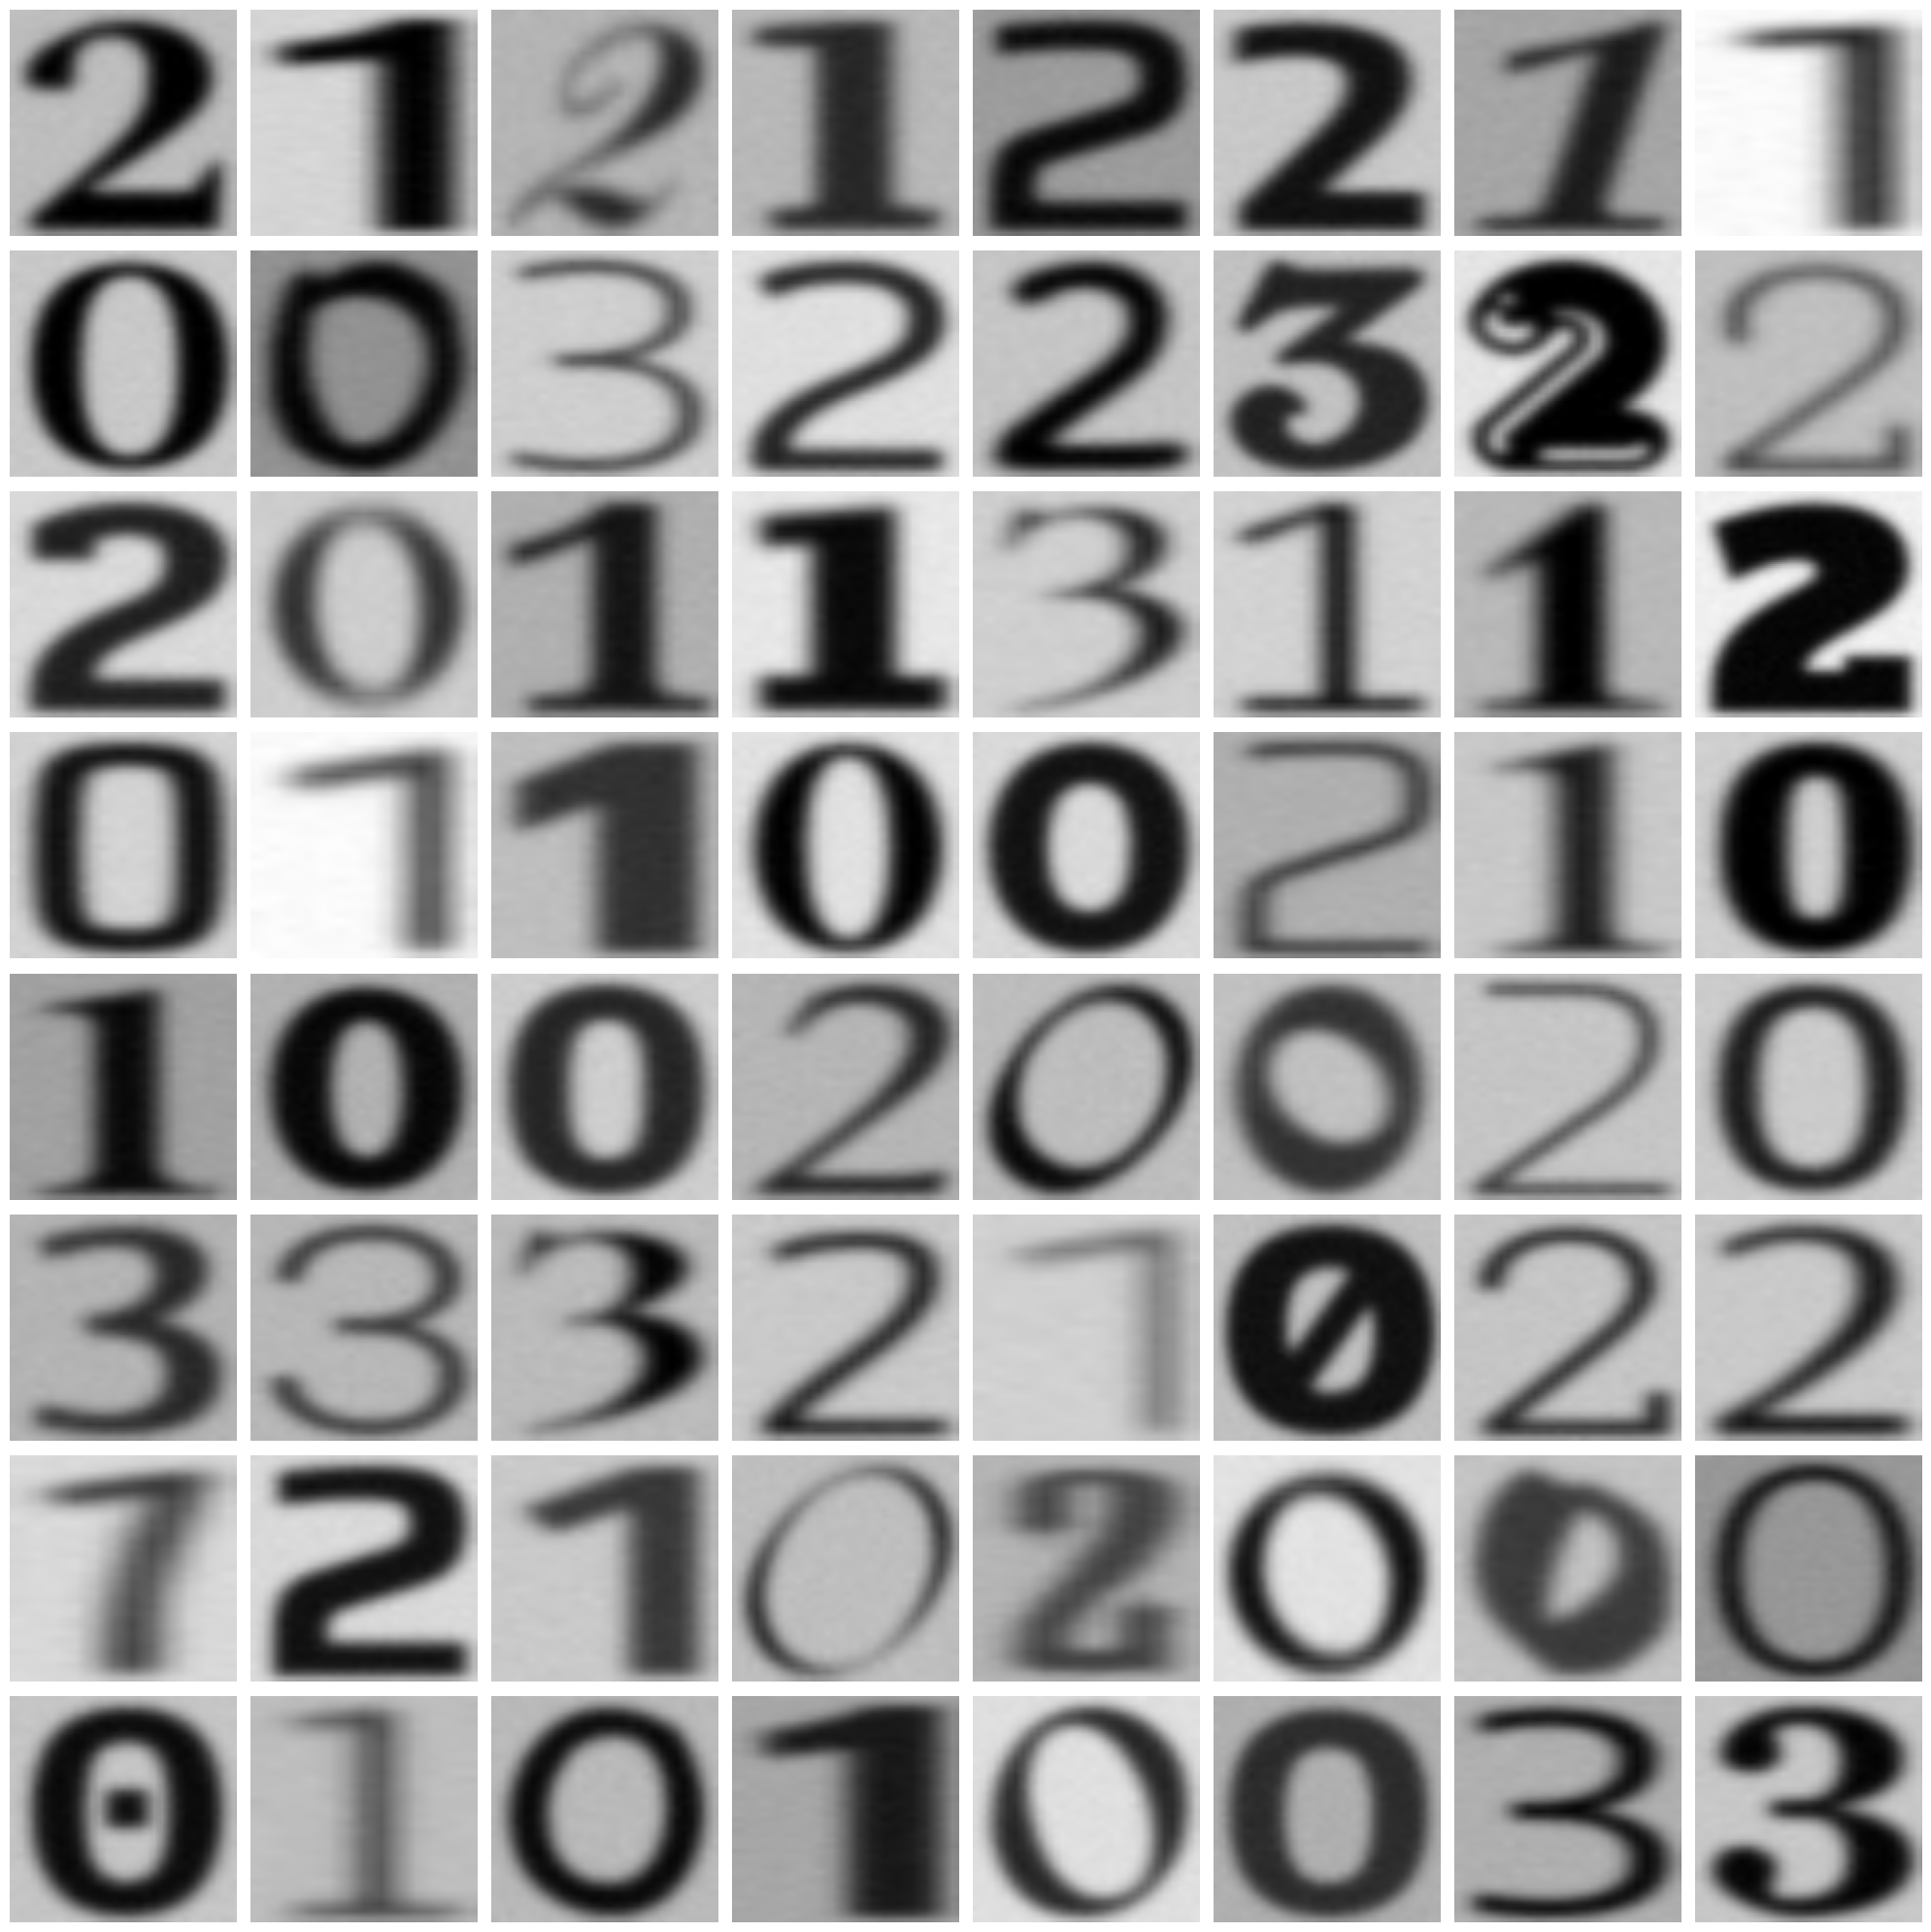

In [16]:
show_images(data=train_ds)

From a **human perspective**, this task seem simple and thanks to the power of **deep learning**, we can tackle it with ease. With the **right tools and techniques**, we can quickly and **accurately identify patterns and trends in our data**, and use them to **drive better outcomes**. So let's put our **deep learning skills to work and see what we can accomplish!**

# **Backbone Comparision**

When it comes to **Transfer Learning**, there's **no shortage of powerful backbones** to choose from. From **ResNet to Xception, Inception to MobileNet, the possibilities are practically endless**. But **which one** is the **best fit** for our **specific task at hand?** Here, we'll be able to **test out multiple backbones** and determine which **one delivers** the best results for **our use case**. So ***let's roll up our sleeves, get to work, and see which backbone comes out on top!***

First, let's load all the backbones.

In [17]:
# Inițializăm MobileNet ca unicul backbone
mobilenet_backbone = tka.MobileNet(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3))
mobilenet_backbone.trainable = False

<ipython-input-17-5025beff0aa2>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_backbone = tka.MobileNet(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


To evaluate the **performance of different backbones** on the OCR dataset, we will create a ***loop*** that will **train and test each backbone**. The loop will iterate through ***ResNet50, ResNet50V2, ResNet152V2, InceptionV3, Xception, and MobileNet***. Once each backbone has been trained and tested, we will **plot the learning curve** for each backbone to assess which one performs the best on the **OCR dataset**. This process will allow us to determine the ***optimal backbone*** to use for our OCR model.

In [20]:
import time
# store the Backbone histories.
# Creăm arhitectura modelului
mobilenet_model = keras.Sequential(layers=[
    layers.InputLayer(input_shape=(*IMAGE_SIZE, 3), name="InputLayer"),
    mobilenet_backbone,
    layers.GlobalAveragePooling2D(name="GAP"),
    layers.Dropout(0.2, name="DropoutLayer"),
    layers.Dense(len(class_names), activation='softmax', name="OutputLayer")
], name="MobileNet")

# Afișăm sumarul modelului
print('-'*100)
print("Model Summary\n")
mobilenet_model.summary()
print('-'*100)

# Compilăm modelul
mobilenet_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Antrenăm modelul
print('-'*100)
print("Model Training\n")
# Măsurarea timpului total de antrenare
start_time = time.time()
mobilenet_history = mobilenet_model.fit(train_ds, validation_data=valid_ds, epochs=20)
end_time = time.time()
total_training_time = end_time - start_time

print(f"Total training time: {total_training_time:.2f} seconds")

print('-'*100)

    # clear the output.
cls()
import os
mobilenet_model.save("mobilnet.keras")
print("Modelul a fost salvat în:", os.path.abspath("mobilnet.keras"))

Modelul a fost salvat în: /content/mobilnet.keras


The **small dummy model** used in this experiment is designed to **establish a baseline for comparison**, rather than to provide the final results. After identifying the best backbone, the **model architecture will be modified**, and the **best parameters will be determined**. To maintain a **fair competition**, **all backbones** are trained with the **same simple architecture and parameters**, and are given ***10 epochs*** for training to **prevent overfitting**. This approach helps to **identify the most effective backbone** in the **shortest possible time**, as **powerful backbones are capable of outperforming expectations**. The ***ultimate goal is to identify the best backbone for the task at hand***.

---
Now that we have **trained and collected the learning curves** for all the backbones, it's time to **visualize them**. This will allow us to **identify the training and testing loss**, as well as the **training and validation accuracy** for each backbone. By ***analyzing these curves***, we can determine which **backbone is performing the best in our task**.

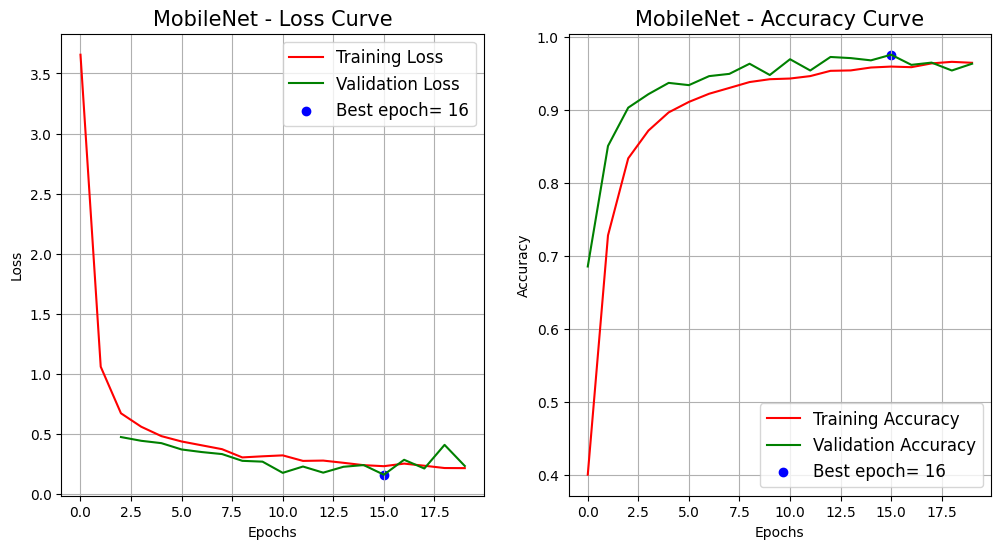

Best epoch: 16


In [21]:
import matplotlib.pyplot as plt


def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Identificarea celui mai bun epoch pe baza celei mai mici valori val_loss
    best_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1

    # Curba Loss
    plt.subplot(1, 2, 1)
    plt.title("MobileNet - Loss Curve", fontsize=15)
    plt.plot(history.history['loss'], 'r-', label='Training Loss')
    plt.plot(history.history['val_loss'], 'g-', label='Validation Loss')
    plt.scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='blue', label=f'Best epoch= {best_epoch}')
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend(fontsize=12)
    plt.grid()

    # Curba Accuracy
    plt.subplot(1, 2, 2)
    plt.title("MobileNet - Accuracy Curve", fontsize=15)
    plt.plot(history.history['accuracy'], 'r-', label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], 'g-', label='Validation Accuracy')
    plt.scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='blue', label=f'Best epoch= {best_epoch}')
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend(fontsize=12)
    plt.grid()

    # Salvare și afișare
    plt.savefig("MobileNet_Learning_Curve_Best_Epoch.png")
    plt.show()

    print(f"Best epoch: {best_epoch}")
plot_training_history(mobilenet_history)
